# Test Code Analysis

In [1]:
import re
import os
from tree_sitter import Language, Parser
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

lang = Language('lang/tree-sitter-languages.so', 'java')
parser = Parser()
parser.set_language(lang)

## Extract assertions for test methods

In [2]:
df = pd.DataFrame(columns=['file', 'test_method', 'assertion_count', 'assertion_list'])

def find_test_methods(tree, source_code):
    test_methods = []

    for node in tree.root_node.children:
        if node.type == 'class_declaration':
            for class_child in node.children:
                if class_child.type == 'class_body':
                    for class_body_child in class_child.children:
                        if class_body_child.type == 'method_declaration':
                            for method_child in class_body_child.children:
                                if method_child.type == 'modifiers' and '@Test' in method_child.text.decode('utf-8'):
                                        test_methods.append(class_body_child.text.decode('utf-8'))

    return test_methods


# Define a function to find assertions in a method
def find_assertions(method_code):
    assertion_count = 0
    assertion_list = []

    # Use regular expression to find method calls starting with "assert"
    assertions = re.findall(r'assert\w*\s*\(.*?\);', method_code)
    for assertion in assertions:
        # Extract the assertion method name
        method_name = assertion.split('(')[0].strip()
        assertion_list.append(method_name)
        assertion_count += 1

    return assertion_count, assertion_list


java_files_dir = 'tests'

# Iterate through Java files
for root, dirs, files in os.walk(java_files_dir):
    for file in files:
        if file.endswith('.java'):
            file_path = os.path.join(root, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                source_code = f.read()
            tree = parser.parse(source_code.encode())
            test_methods = find_test_methods(tree, source_code)
            for method in test_methods:
                assertion_count, assertion_list = find_assertions(method)
                # insert into dataframe
                df = df._append({'file': file, 'test_method': method, 'assertion_count': assertion_count,
                                'assertion_list': assertion_list}, ignore_index=True)

In [3]:
df

,file,test_method,assertion_count,assertion_list
0,OptionGroupTest_Method_18_Run_20231030_094427....,@Test\n public void testAddOptionToEmptyGro...,2,"[assertEquals, assertEquals]"
1,OptionGroupTest_Method_18_Run_20231030_094427....,@Test\n public void testAddOptionToNonEmpty...,3,"[assertEquals, assertTrue, assertTrue]"
2,OptionGroupTest_Method_18_Run_20231030_094427....,@Test\n public void testAddOptionWithDuplic...,2,"[assertEquals, assertEquals]"
3,OptionsTest_Method_8_Run_20231024_091429.java,@Test\n public void testGetOptionShortName(...,1,[assertEquals]
4,OptionsTest_Method_8_Run_20231024_091429.java,@Test\n public void testGetOptionLongName()...,1,[assertEquals]
...,...,...,...,...
2561,CommandLineTest_Method_134_Run_20231023_214133...,@Test\n public void testGetOptionProperties...,1,[assertEquals]
2562,CommandLineTest_Method_134_Run_20231023_214133...,@Test\n public void testGetOptionProperties...,1,[assertEquals]
2563,HelpFormatterTest_Method_206_Run_20231025_1050...,@Test\n void testSetArgNameValidString() {\...,1,[assertEquals]
2564,HelpFormatterTest_Method_206_Run_20231025_1050...,@Test\n void testSetArgNameNull() {\n ...,1,[assertNull]


## Plot results

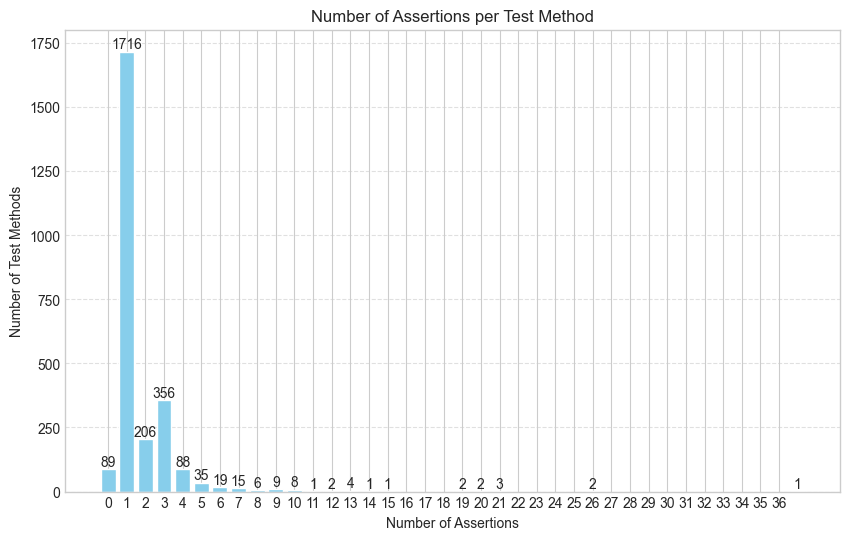

In [6]:
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-whitegrid')
bar = plt.bar(df['assertion_count'].value_counts().index, df['assertion_count'].value_counts().values, color='skyblue')
plt.bar_label(bar)
plt.xticks(np.arange(0, 37, 1))
plt.xlabel('Number of Assertions')
plt.ylabel('Number of Test Methods')
plt.title('Number of Assertions per Test Method')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig('assertion_counts.png', dpi=300, bbox_inches='tight')
plt.show()

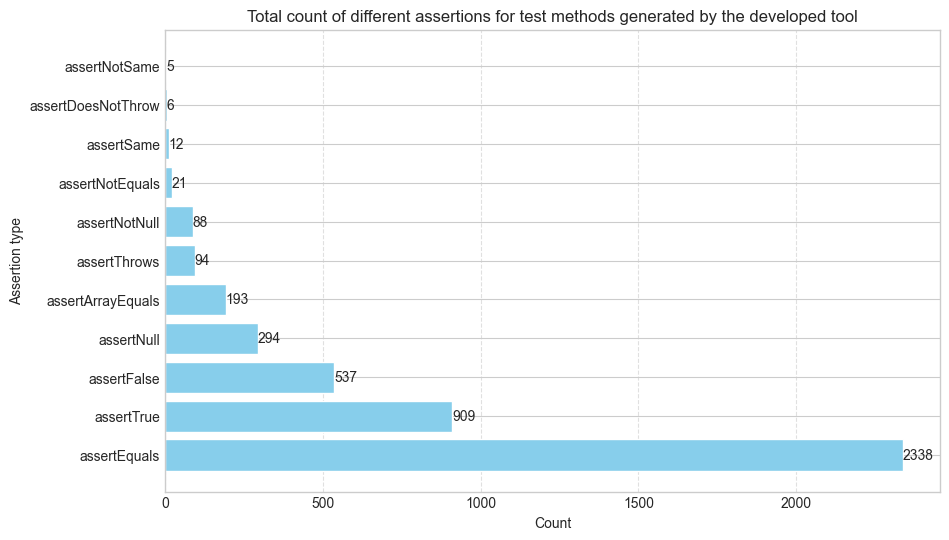

In [17]:
# plot type of assertions as bar chart
# Flatten the list of assertions into a single list
all_assertions = [assertion for assertions in df['assertion_list'] for assertion in assertions]

# Count the occurrences of each assertion
assertion_counts = {assertion: all_assertions.count(assertion) for assertion in set(all_assertions)}

# Create a DataFrame for plotting
assertion_df = pd.DataFrame(list(assertion_counts.items()), columns=['Assertion', 'Count'])

# Sort the DataFrame by count (optional)
assertion_df = assertion_df.sort_values(by='Count', ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-whitegrid')
bar = plt.barh(assertion_df['Assertion'], assertion_df['Count'], color='skyblue')
plt.bar_label(bar)
plt.xlabel('Count')
plt.ylabel('Assertion type')
plt.title('Total count of different assertions for test methods generated by the developed tool')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.savefig('assertion_types.png', dpi=300, bbox_inches='tight')
plt.show()

## Analyze Evosuite tests

In [18]:
df_evosuite = pd.DataFrame(columns=['file', 'test_method', 'assertion_count', 'assertion_list'])

java_files_dir = 'evosuite-tests-simplified'

# Iterate through Java files
for root, dirs, files in os.walk(java_files_dir):
    for file in files:
        if file.endswith('.java'):
            file_path = os.path.join(root, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                source_code = f.read()
            tree = parser.parse(source_code.encode())
            test_methods = find_test_methods(tree, source_code)
            for method in test_methods:
                assertion_count, assertion_list = find_assertions(method)
                # insert into dataframe
                df_evosuite = df_evosuite._append({'file': file, 'test_method': method, 'assertion_count': assertion_count,
                                'assertion_list': assertion_list}, ignore_index=True)

In [19]:
df_evosuite

,file,test_method,assertion_count,assertion_list
0,OptionBuilder_ESTest.java,@Test(timeout = 4000)\n public void test00() ...,1,[assertNotNull]
1,OptionBuilder_ESTest.java,@Test(timeout = 4000)\n public void test01() ...,2,"[assertEquals, assertEquals]"
2,OptionBuilder_ESTest.java,@Test(timeout = 4000)\n public void test02() ...,1,[assertEquals]
3,OptionBuilder_ESTest.java,@Test(timeout = 4000)\n public void test03() ...,2,"[assertEquals, assertTrue]"
4,OptionBuilder_ESTest.java,@Test(timeout = 4000)\n public void test04() ...,1,[assertEquals]
...,...,...,...,...
512,AlreadySelectedException_ESTest.java,@Test(timeout = 4000)\n public void test06() ...,1,[assertFalse]
513,AlreadySelectedException_ESTest.java,@Test(timeout = 4000)\n public void test07() ...,1,[assertFalse]
514,AlreadySelectedException_ESTest.java,@Test(timeout = 4000)\n public void test08() ...,1,[assertEquals]
515,AlreadySelectedException_ESTest.java,@Test(timeout = 4000)\n public void test09() ...,0,[]


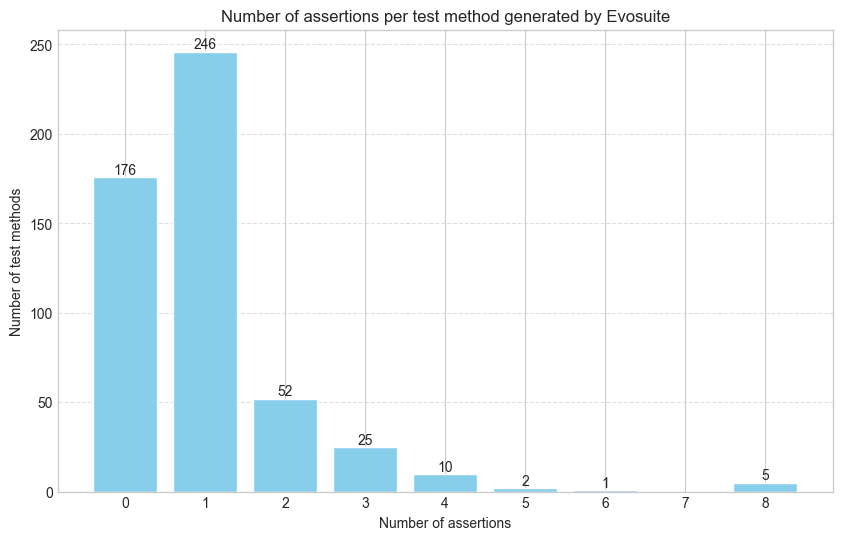

In [14]:
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-whitegrid')
bar = plt.bar(df_evosuite['assertion_count'].value_counts().index, df_evosuite['assertion_count'].value_counts().values, color='skyblue')
plt.bar_label(bar)
plt.xticks(np.arange(0, 9, 1))
plt.xlabel('Number of assertions')
plt.ylabel('Number of test methods')
plt.title('Number of assertions per test method generated by Evosuite')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig('assertion_counts_evosuite.png', dpi=300, bbox_inches='tight')
plt.show()

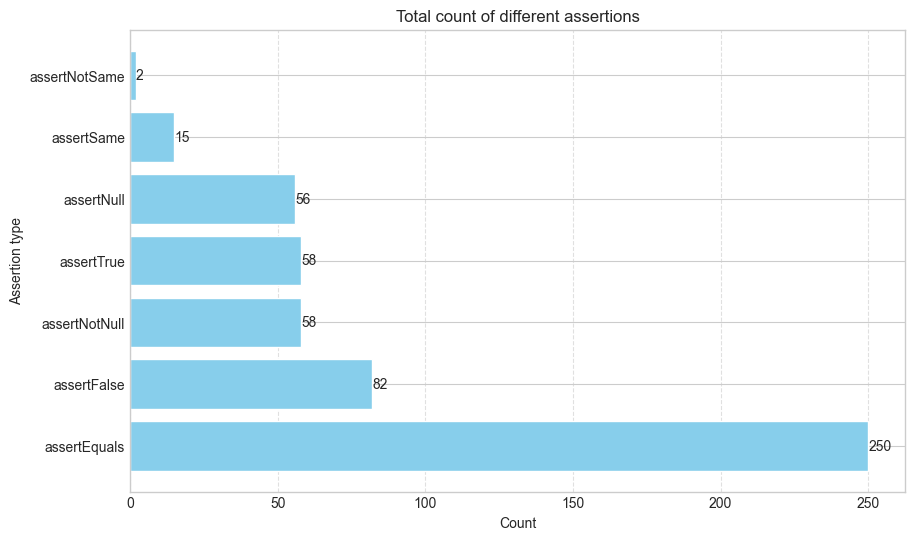

In [20]:
# plot type of assertions as bar chart
# Flatten the list of assertions into a single list
all_assertions = [assertion for assertions in df_evosuite['assertion_list'] for assertion in assertions]

# Count the occurrences of each assertion
assertion_counts = {assertion: all_assertions.count(assertion) for assertion in set(all_assertions)}

# Create a DataFrame for plotting
assertion_df = pd.DataFrame(list(assertion_counts.items()), columns=['Assertion', 'Count'])

# Sort the DataFrame by count (optional)
assertion_df = assertion_df.sort_values(by='Count', ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-whitegrid')
bar = plt.barh(assertion_df['Assertion'], assertion_df['Count'], color='skyblue')
plt.bar_label(bar)
plt.xlabel('Count')
plt.ylabel('Assertion type')
plt.title('Total count of different assertions')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.savefig('assertion_types_evosuite.png', dpi=300, bbox_inches='tight')
plt.show()